In [ ]:
import pandas as pd
import numpy as np
import os
import random
import warnings
import pandas_profiling
import scipy.stats
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures,PowerTransformer,QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
from sklearn.impute import KNNImputer
from scipy.stats import mstats
from scipy.stats import norm
from scipy import stats
from statsmodels.api import OLS
plt.rcParams['figure.figsize'] = 10, 10
plt.style.use('bmh')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Basic Part

## 1. Regression

In [ ]:
path = "/content/drive/MyDrive/AirQualityUCI.csv"
df = pd.read_csv(path,sep=";",na_values="-200",decimal=",")
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


### 1.1 EDA and Data Prep. from HW3
https://colab.research.google.com/drive/1HxFRThv287ogEuk5ObdYAJIg3Q0ICNj4?usp=sharing#scrollTo=lmPO6kSEw8OE

In [ ]:
df = df.drop(columns=["Unnamed: 15","Unnamed: 16"])

In [ ]:
TARGET = "C6H6(GT)";
SEED = 42;

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


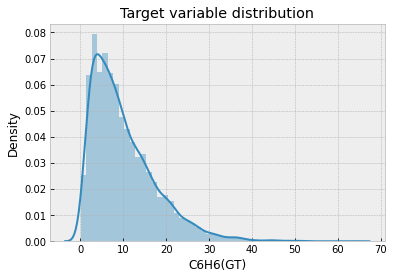

In [ ]:
ax = sns.distplot(df["C6H6(GT)"], norm_hist=True)
ax.set_title('Target variable distribution');

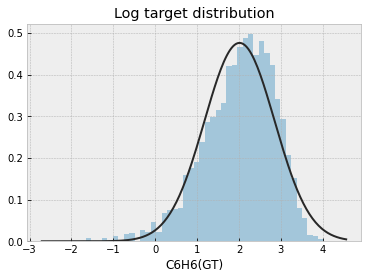

In [ ]:
ax = sns.distplot(np.log(df["C6H6(GT)"]), norm_hist=True,fit=norm,kde=False)
ax.set_title('Log target distribution');

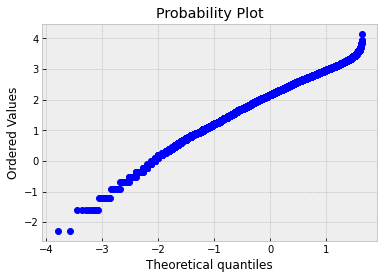

In [ ]:
res = stats.probplot(np.log(df["C6H6(GT)"]), plot=plt)

In [ ]:
#pandas_profiling.ProfileReport(df)


Overview of Profiling:

1) NMHC(GT) has high correlation with target, but has 90% of missing values, so this feature has to be dropped

2) Target variable is C6H6(GT) HIGHLY (nearly one) correlated with some other features

3) There are rows of NaNs that should be dropped, and not imputed 

4) All features are numeric, making it easier to preprocess

5) A lot of features has exactly the same number of missing values, which means it's likely just NaN strings with 1 or 2 not NaN value




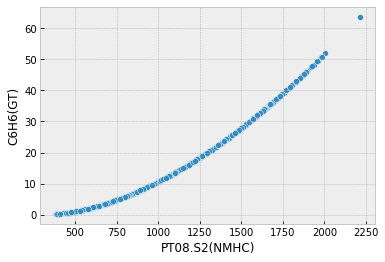

In [ ]:
#better look at highly-correlated features
ax = sns.scatterplot(data=df, x="PT08.S2(NMHC)", y="C6H6(GT)")

In [ ]:
#empty strings are useless
df.dropna(how="all",inplace=True)

#more than 90% of data is missing
df.drop(columns=["NMHC(GT)"],inplace=True)

With that high correlation may be this one feature is enough, will see later

#### Time features

In [ ]:
#cast to dt from object
df["Time"] = pd.to_datetime(df['Time'],format="%H.%M.%S").dt.hour #everything is :00 
Date = pd.to_datetime(df['Date'])
Date.dt.date

0       2004-10-03
1       2004-10-03
2       2004-10-03
3       2004-10-03
4       2004-10-03
           ...    
9352    2005-04-04
9353    2005-04-04
9354    2005-04-04
9355    2005-04-04
9356    2005-04-04
Name: Date, Length: 9357, dtype: object

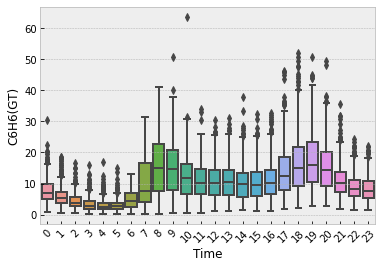

In [ ]:
p = sns.boxplot(x=df["Time"],y=df["C6H6(GT)"]);
p.set_xticklabels(p.get_xticklabels(), rotation=45);
ax.set_title('Boxplot for each hour');

Time of the day really matters, but here we got a problem -- what kind of variable time is? It seems like ordinal one, because 19:00 > 06:00, but time is cyclical, which means 23:00 should be very close to 00:00, and so one.

Let's make time cyclical, transforming it's value to two new parameters "sin_time" and "cos_time". Together, they are creating time circle, where model can use the cyclycity of time

Text(0.5, 1.0, 'New values of Time toghere')

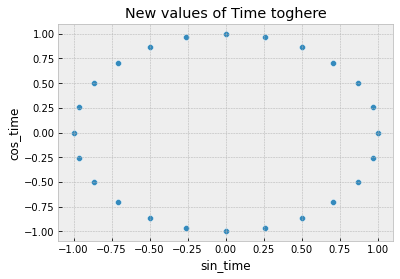

In [ ]:
df["sin_time"]  = np.sin(2*np.pi*df["Time"]/24)
df["cos_time"]  = np.cos(2*np.pi*df["Time"]/24)
df.drop(columns=["Time"],inplace=True)
ax = sns.scatterplot(x = "sin_time",y = "cos_time", data = df)
ax.set_title('New values of Time toghere')

Looks like time of the day  is realy important



Since considering specific date is useless (this date will never repeat) let's try to find some pattern in month or day of week.

In [ ]:
#create new features with int type for simplify working with Time
df["Month"] = Date.dt.month.astype(np.int64)
df["DayOfWeek"] = Date.dt.dayofweek.astype(np.int64)
df.drop(columns=["Date"],inplace=True);


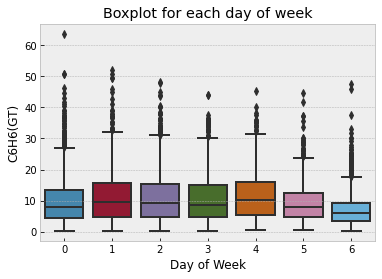

In [ ]:
ax = sns.boxplot(x=Date.dt.dayofweek,y="C6H6(GT)",data=df);
ax.set_title('Boxplot for each day of week');
ax.set_xlabel('Day of Week');

It seems like Day of Week matters -- let's check that using Kruskal-Wallis test (comparing medians)

In [ ]:
#split data among day of week -- creating an array of target variable for each Day of Week
args = [df[df["DayOfWeek"] == i][TARGET].values for i in range(0,6)]

mstats.kruskalwallis(*args)

KruskalResult(statistic=58.81273038668838, pvalue=2.137778523739574e-11)

pvalue is extremly low -> they have significantly different medians, 

same applies for months

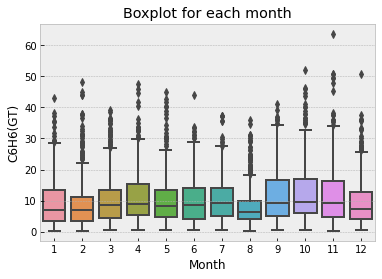

In [ ]:
ax = sns.boxplot(x=Date.dt.month,y="C6H6(GT)",data=df);

ax.set_title('Boxplot for each month');
ax.set_xlabel('Month');

#### Data preparation

In [ ]:
df.dtypes

CO(GT)           float64
PT08.S1(CO)      float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
sin_time         float64
cos_time         float64
Month              int64
DayOfWeek          int64
dtype: object

In [ ]:
NUMERICAL = df.select_dtypes(include=['float64']).columns.tolist()
CATEGORICAL =  df.select_dtypes(include=['int64']).columns.tolist()#the only cat-features in this df is Month and Day of week which are integers right now
if TARGET in NUMERICAL:
    NUMERICAL.remove(TARGET)

In [ ]:
df.isna().sum()

CO(GT)           1683
PT08.S1(CO)       366
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
sin_time            0
cos_time            0
Month               0
DayOfWeek           0
dtype: int64

Most of the features have *exactly* 366 missing values, including our target variable. Looks like they all are missing simultaneously. If so, there is no need to impute nearly empty string, considering target variable is also missing.

Let's check that

In [ ]:
#all string target is missing
df_null = df.loc[df["C6H6(GT)"].isnull()]
#count other missing
df_null.isna().sum()

CO(GT)            36
PT08.S1(CO)      366
C6H6(GT)         366
PT08.S2(NMHC)    366
NOx(GT)           44
PT08.S3(NOx)     366
NO2(GT)           44
PT08.S4(NO2)     366
PT08.S5(O3)      366
T                366
RH               366
AH               366
sin_time           0
cos_time           0
Month              0
DayOfWeek          0
dtype: int64

In [ ]:
df_null.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,sin_time,cos_time,Month,DayOfWeek
524,1.7,NaN,NaN,NaN,99.0,NaN,72.0,NaN,NaN,NaN,NaN,NaN,-0.500000,-0.866025,1,6
525,1.9,NaN,NaN,NaN,108.0,NaN,81.0,NaN,NaN,NaN,NaN,NaN,-0.707107,-0.707107,1,6
526,2.3,NaN,NaN,NaN,131.0,NaN,93.0,NaN,NaN,NaN,NaN,NaN,-0.866025,-0.500000,1,6
701,2.0,NaN,NaN,NaN,129.0,NaN,106.0,NaN,NaN,NaN,NaN,NaN,-0.258819,0.965926,8,2
702,2.4,NaN,NaN,NaN,154.0,NaN,109.0,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,9,5


That's it, all this features are missing in same strings, which means it's nearly empty string.

In [ ]:
#again -- dropping only because it's nearly empty strings
df = df.dropna(subset=["C6H6(GT)"])
df.isna().sum()

CO(GT)           1647
PT08.S1(CO)         0
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)          1595
PT08.S3(NOx)        0
NO2(GT)          1598
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
sin_time            0
cos_time            0
Month               0
DayOfWeek           0
dtype: int64

In [ ]:
#let's separate in 3 parts -- train, test, validation
target = df[TARGET].values
X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET, axis=1), target, 
                                                  random_state=SEED, shuffle=False, test_size = 0.2)
#shuffle false cause of time series

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  random_state=SEED, shuffle=False, test_size = 0.2)


As imputer *KNNImputer* is used due to the fact that we have relatively high correlation between features, so finding similiar group of strings to calculate the impute value must be a good prediction, since they all are connected

In [ ]:
numeric_transformer = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERICAL),
        ('cat', categorical_transformer, CATEGORICAL)
        ])

In [ ]:
X_train_pr = preprocessor.fit_transform(X_train)

In [ ]:
X_val_pr = preprocessor.transform(X_val)

### 1.2 Neural Network approach

#### 1.2.1 TensorFlow/Keras

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.0


In [ ]:
pip install tensorflow-addons

In [ ]:
import tensorflow_addons as tfa

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train_pr.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  # loss function and metrics is chosen based on HW3 to perform proper comparison
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))])
  return model

In [ ]:
model = build_model()

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 50 == 0: print('')
    print('.', end='')

EPOCHS = 250

history = model.fit(
  X_train_pr, np.log(y_train),
  epochs=EPOCHS, validation_data =(X_val_pr,np.log(y_val)), verbose=0,callbacks=[PrintDot()])


..................................................
..................................................
..................................................
..................................................
..................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist.head()

,loss,root_mean_squared_error,r_square,val_loss,val_root_mean_squared_error,val_r_square
0,0.346351,0.588516,0.413394,0.318309,0.564189,0.601227
1,0.020631,0.143634,0.965058,0.137316,0.370562,0.827972
2,0.012300,0.110903,0.979169,0.096812,0.311147,0.878715
3,0.009908,0.099537,0.983220,0.069805,0.264206,0.912550
4,0.008420,0.091759,0.985740,0.065043,0.255034,0.918516


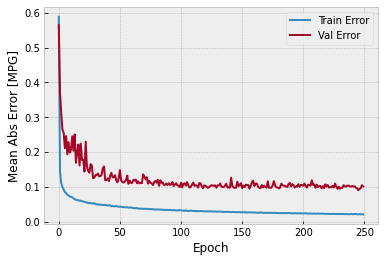

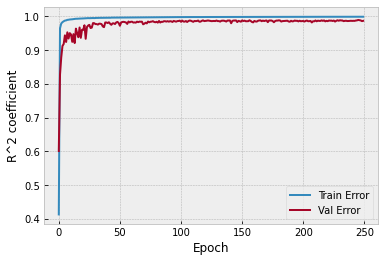

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['root_mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_root_mean_squared_error'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('R^2 coefficient')
  plt.plot(hist['epoch'], hist['r_square'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_r_square'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

Early-stopping


..................................................
..................................................
..................................................
..................................................
.......................

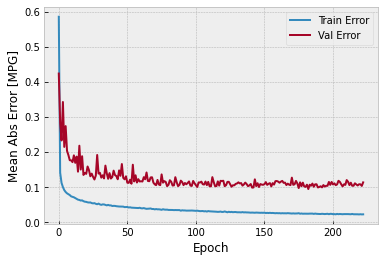

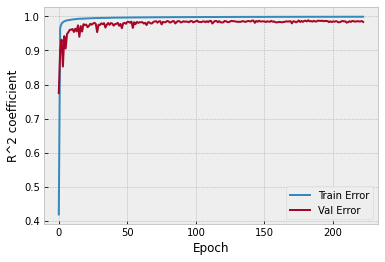

In [ ]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

history = model.fit(X_train_pr, np.log(y_train), epochs=EPOCHS,
                    validation_data = (X_val_pr,np.log(y_val)), verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

So in fact only ~250 epochs is enough, which is time-saving information.

In [ ]:
X_test_pr = preprocessor.transform(X_test)

In [ ]:
y_pred = model.predict(X_test_pr) #check on test

##### **Сomparison of methods**

In [ ]:
def model_observe(y_true, y_pred):
    return pd.DataFrame({
        'test_RMSE': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'test_R2': [r2_score(y_true, y_pred)]
    })

In this dataset there is an nonlinear relationship between features and target.In HW3 there were several approaches -- with poly-features, and w/o. Let's compare results with both of them:

**A)** LinReg **without** polynomic features

(screenshot to save some time by NOT repeating all LineReg steps, proof can be found using link to HW3 above)

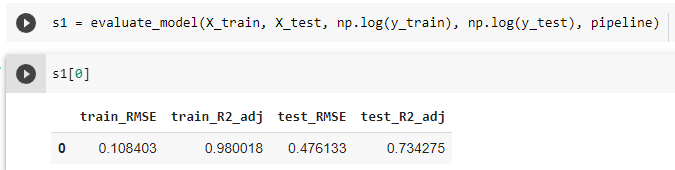

**B)** LinReg with manual **added poly-feature** and removing unimportant features

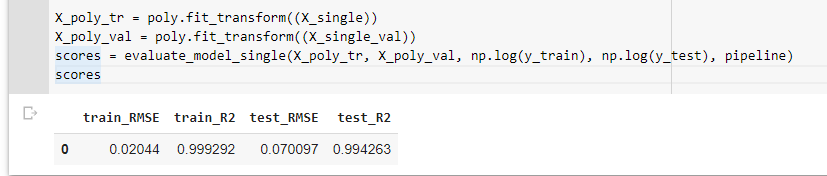

NN results:

In [ ]:
# train results are not interesting at all -- 
# NN is well known to perform very good on train sets
model_observe(np.log(y_test),y_pred)

,test_RMSE,test_R2
0,0.116491,0.984157


**Conclusion:**

NN without any feature engineering perfomed much better than LinReg without polyfeatures.
This is simple illustration that due to activation functions NN can perform better with non-linear relationships without considering them manualy, while LinReg obviously has a problem with non-linear data.

Resluts of NN are even close to manually tuned LineReg with poly-features, but slightly worse. This means that properly tuned LinReg can still outperform NN approach, and also LinReg will no be "blackbox", as it coef. can be interpreted. 

TLDR:

NN is good at finding non-linear relationship without any tuning, but proper setup of Lin. Regression can outperfrom NN if "true relationship" (or close to it) is found.

#### 1.2.2 PyTorch

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

In [ ]:
#just the same model used in TF 

net = nn.Sequential(
          nn.Linear(X_train_pr.shape[1], 64),
          nn.ReLU(),
          nn.Linear(64, 64),
          nn.ReLU(),
          nn.Linear(64, 1),
        )
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()

To take advantages of DataLoader let's combine back out data to train,val,test DataSets with special methods

In [ ]:
device = "cpu"

In [ ]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#Float is expected by default, but Double returned instead
train_dataset = RegressionDataset(torch.from_numpy(X_train_pr).float(), torch.from_numpy(np.log(y_train)).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val_pr).float(), torch.from_numpy(np.log(y_val)).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test_pr).float(), torch.from_numpy(np.log(y_test)).float())

Now we have ready-to-work tensors which could be used in DataLoader

In [ ]:
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
loss_func = nn.MSELoss()

In [ ]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)): #observe progress
  
  # Training part
  train_epoch_loss = 0
  _ = net.train();
  for X_train_batch, y_train_batch in train_loader:

      #possibility to use GPU
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
      
      #learning procces itself
      optimizer.zero_grad()
      y_train_pred = net(X_train_batch) 
      train_loss = loss_func(y_train_pred, y_train_batch.unsqueeze(1))  
      train_loss.backward()
      optimizer.step()
      
      #save losses
      train_epoch_loss += train_loss.item()
      
  # VALIDATION 

  #disable gradient-calculations
  with torch.no_grad():
      val_epoch_loss = 0
      _ = net.eval();

      for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          
          #during validation it just calculates loss-function
          y_val_pred = net(X_val_batch)
          val_loss = loss_func(y_val_pred, y_val_batch.unsqueeze(1))
          val_epoch_loss += val_loss.item()

  #save train-val losses to plot later
  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(val_loader)) 

  #print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/150 [00:00<?, ?it/s]

Let's plot learning curve (starting with epoch where drop is signnificant)

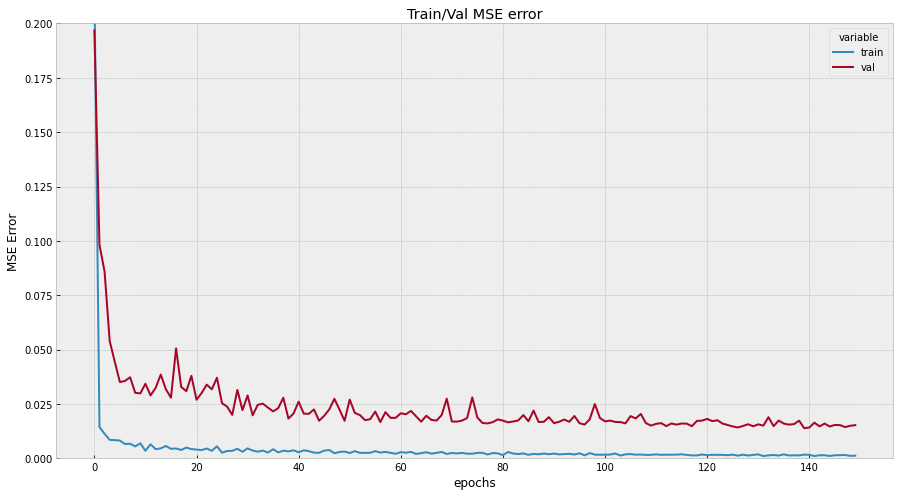

In [ ]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"});
plt.figure(figsize=(15,8));
g = sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable");
g.set_title("Train/Val MSE error");
g.set_ylabel("MSE Error");

g.set(ylim=(0, 0.2));

##### **Comparison to other methods**

In [ ]:
#comparison on test-set
y_pred = net(torch.tensor(X_test_pr).float())

In [ ]:
model_observe(np.log(y_test),y_pred.detach().numpy())

,test_RMSE,test_R2
0,0.153095,0.972636


#####  **Conclusion**

PyTorch results it slighly better than TF ones:

 RMSE 0.12331 vs 0.131544 

 R2 0.982245 vs 0.979798

 So in terms of comparison with LinReg applies all the same.
 Comparison between themselves:

 With same NN structure (layers,optimizers, LR) PyTorch perfomed better and slightly faster according to Collab timers, but it's hard to compare them since:

 1) None of these NN structures were properly tuned

 2) stochastic nature of back-propagation could be the reason of that little diffrence 

**UPDATE**

*While re-starting notebook we get different values for RMSE and R2 (which is obvious since procces is stochastic, and last time PyTorch perfomed worse.
Anyway reasons 1-2 are still valid





---



## 2. Classification

Classification HW: https://colab.research.google.com/drive/1WJzFNhZVXRw6cPqTHS1CojqkcSAFiSNI?usp=sharing#scrollTo=JBnrNMHKju8l

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder,OrdinalEncoder

from sklearn.metrics import precision_recall_curve,fbeta_score,roc_auc_score

In [ ]:
path = "/content/drive/MyDrive/dataset_57_hypothyroid.csv"
df = pd.read_csv(path,na_values="?",sep=",")
df.tail()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
3767,30.0,F,f,f,f,f,f,f,f,f,f,f,f,t,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
3768,68.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.0,t,2.1,t,124.0,t,1.08,t,114.0,f,NaN,SVI,negative
3769,74.0,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,t,5.1,t,1.8,t,112.0,t,1.07,t,105.0,f,NaN,other,negative
3770,72.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.7,t,2.0,t,82.0,t,0.94,t,87.0,f,NaN,SVI,negative
3771,64.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.0,t,2.2,t,99.0,t,1.07,t,92.0,f,NaN,other,negative


### 2.1 EDA (copied from link above)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

**Overview of Profiling:**

1) TBG_measured is 100% false, which means TBG is 100% NaN. Useless features, should be dropped

2) Boolean variables (exluding sex) are very unbalanced, since they are indicating some rare condition (such as pregnancy, tumor, e.t.c), so is the target one.

3)Age has an obvious mistake  (Max age is 422) while other features have an outliars too, but it's hard to say is it mistake or very big value

**Class problem**

Target variable have 4 classes, "negative" and 3 classes of deseased people. Last class "secondary_hypothyroid" contains only 2 variable. 
Since it contain only 2 example in the ENTIRE dataset (which should be also splitted in train/test). Each of the set will contain only one example of data, which is not enough even for upsampling or some other techniques. Dublicating single value will result in model errors and SMOT algorithms cant be perfom using single value. 


In [ ]:
df['Class'].value_counts() #3770

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64


This class will ruin the model average metric (using the macro one), since classifier can't learn properly on single example. Usingle minor average is solving the problem, but also creating another one -- 92% of the dataset is healthy people, which are easy to correctly predict. Which means this class will dominate the minor metric.

Since there is no way to correctly classify "secondary_hypothyroid" Class (its values are not even extreme ones in terms of numeric features) using only 1 value, the decision is made **to avoid this class**, and build classifier which do not recognizer this type of desease.

In [ ]:
df.drop(df.index[df['Class'] == 'secondary_hypothyroid'], inplace = True)

In [ ]:
#empty columns
df.drop(columns=["TBG_measured","TBG"],inplace=True)

In [ ]:
BOOLEANS = [col for col in df.select_dtypes(include=['object']).columns.tolist() if col not in ["Class","sex","referral_source"]];

NUMERIC = [col for col in df.select_dtypes(include=['float64']).columns.tolist()];

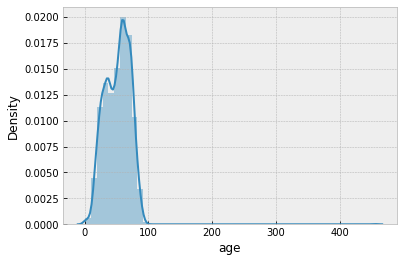

In [ ]:
sns.distplot(df["age"]);

Age has an mistake, not the outliar, therefore deleting the entire row is not needed, we can simply impute new age value.

In [ ]:
MISTAKE_AGE_THRESH = 110

mistakes = df[df["age"]>MISTAKE_AGE_THRESH]["age"]
df["age"].replace([mistakes],np.nan,inplace=True) #filling this values to nan, to impute them later


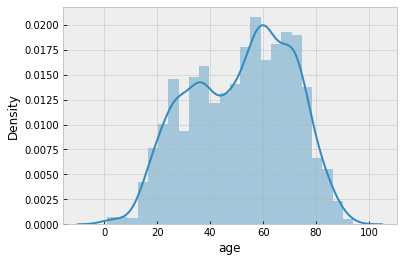

In [ ]:
sns.distplot(df["age"]);

Let's try to see how single boolean feature affect class.

Plot below is showing how many "deseased" targets (percentage) each boolean has per value. 

For the simplicity of the analysis, all hyperthyroids classes are combined in "healthy" one, indicating was the hyperthyroid detected or not


Outliers from numeric features are NOT being removed, because they indicate some blood measurements which can be extremly high in case of hypothyroid

In [ ]:
healthy = df.loc[df["Class"]=="negative"]
deseased = df.loc[df["Class"]!="negative"]

### 2.2 Data preporation

Firstly, let's encode "object" to another types

In [ ]:
df.drop(df.index[df['Class'] == 'secondary_hypothyroid'], inplace = True)

In [ ]:
df["sex"] = df["sex"].map({'F': 0, 'M': 1}); #the patriarchal world itself;


In [ ]:
df.dtypes

age                          float64
sex                          float64
on_thyroxine                  object
query_on_thyroxine            object
on_antithyroid_medication     object
sick                          object
pregnant                      object
thyroid_surgery               object
I131_treatment                object
query_hypothyroid             object
query_hyperthyroid            object
lithium                       object
goitre                        object
tumor                         object
hypopituitary                 object
psych                         object
TSH_measured                  object
TSH                          float64
T3_measured                   object
T3                           float64
TT4_measured                  object
TT4                          float64
T4U_measured                  object
T4U                          float64
FTI_measured                  object
FTI                          float64
referral_source               object
C

In [ ]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Class
0,41.0,0.0,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.30,t,2.5,t,125.0,t,1.14,t,109.0,SVHC,negative
1,23.0,0.0,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.10,t,2.0,t,102.0,f,NaN,f,NaN,other,negative
2,46.0,1.0,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109.0,t,0.91,t,120.0,other,negative
3,70.0,0.0,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175.0,f,NaN,f,NaN,other,negative
4,70.0,0.0,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61.0,t,0.87,t,70.0,SVI,negative


Only Thyroid Function Tests are missing. Because it's very important features,strings where at least 3 of this numeric indexes are missing at the same time should be deleted, because it will be too hard to correctly impute them

In [ ]:
df.drop(columns=["referral_source"],inplace=True)
df.dropna(thresh = df.columns.size-3,inplace=True)

#Measurement fact is not needed, 
df.drop(columns=["TSH_measured","T3_measured","T4U_measured","TT4_measured","FTI_measured"],inplace=True)

In [ ]:
#upd
BOOLEANS = [col for col in df.select_dtypes(include=['object']).columns.tolist() if col not in ["Class","sex","referral_source"]];

In [ ]:
df["Class"] = df["Class"].apply(lambda x: ['negative', 'compensated_hypothyroid', 'primary_hypothyroid'].index(x));

In [ ]:
df.isna().sum()

age                            2
sex                          137
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          165
T3                           570
TT4                            6
T4U                          160
FTI                          158
Class                          0
dtype: int64

In [ ]:
#let's separate train/test
TARGET = "Class";
SEED = 42;
target = df[TARGET].values
X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET, axis=1), target, 
                                                  random_state=SEED, shuffle=True, stratify=df[TARGET], test_size = 0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  random_state=SEED, shuffle=True, stratify=y_train, test_size = 0.2)

In [ ]:
#feature encoding 

numeric_transformer = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ])

booleans_transformer = OrdinalEncoder() #boolean case 0 and 1 value -- just fine

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC),
        ('cat', categorical_transformer, ["sex"]),
        ('bool',booleans_transformer,BOOLEANS)
        ])

Target encoding is not used since LogisticRegression() and KNNeighbours() use "*y-array-like of shape (n_samples,)*" and do encoding inside.



In [ ]:
X_train_pr = preprocessor.fit_transform(X_train)
X_val_pr = preprocessor.fit_transform(X_val)
X_test_pr = preprocessor.transform(X_test)

### 2.3 Neural Network classification

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train_pr = to_categorical(y_train, 3)
y_val_pr = to_categorical(y_val,3)
y_test_pr = to_categorical(y_test, 3)

#### 2.3.1 TensorFlow/Keras

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train_pr.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(3, activation='softmax')
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  # loss function and metrics is chosen based on HW to perform proper comparison
  # AUC of PR-curve was chosen in HW
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(curve="PR")])
  return model

In [ ]:
model = build_model()

In [ ]:
class_weight = {0: 1.,
                1: 19.,
                2: 9.}

In [ ]:
EPOCHS = 500

history = model.fit(
  X_train_pr, y_train_pr,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,class_weight = class_weight,callbacks=[PrintDot()])


..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist.tail()

,loss,auc,val_loss,val_auc
495,0.000473,1.0,0.386747,0.973793
496,0.000266,1.0,0.385785,0.973800
497,0.000302,1.0,0.387173,0.973810
498,0.000287,1.0,0.387909,0.973814
499,0.000538,1.0,0.389670,0.973857


In [ ]:
y_pred = model.predict(X_test_pr)

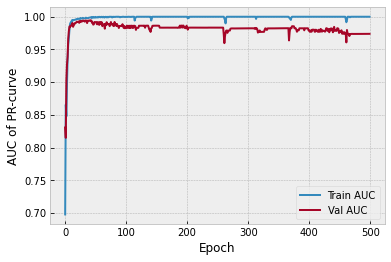

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('AUC of PR-curve')
  plt.plot(hist['epoch'], hist.iloc[:,1],
           label='Train AUC')
  plt.plot(hist['epoch'], hist.iloc[:,3],
           label = 'Val AUC')
  plt.legend()

plot_history(history)

Model tends to overfit a lot after ~80 epoch, let's use early-stopping 


.............................................

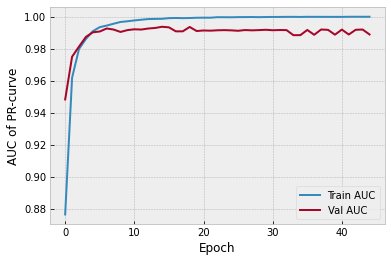

In [ ]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(
  X_train_pr, y_train_pr,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,callbacks=[early_stop,PrintDot()])

plot_history(history)

Test set AP:

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:
y_prob = model.predict(X_test_pr)

print("AP results of TF on test set:",average_precision_score(y_test_pr,y_prob,average="micro"))

AP results of TF on test set: 0.9971246433634964


##### **Comparison with classification**

With only one tuning (class_weights -- since we have highly imbalance classification problem) NN shows it can outperfom most of classifiers 

*NOTE* -- results are from HW4, which was "long time ago in a galaxy far away" so some of these classifiers, probably, were not perfectly tuned.


NN: **0.99712**

Combined results of AP (taken from HW4)

Tuned Classifiers:
KNN : **0.98**

LogReg: **0.917**

RandomForest: **0.99**

NN with no tuning performs very good while being still relatively fast. It is outperforming each algorithm except RF, they are showing ~similiar results on test set.

#### 2.3.2 PyTorch

In [ ]:
class_weights = [1,19,8]
tch_weights = torch.FloatTensor(class_weights).to(device)

In [ ]:
#just the same model used in TF 

net = nn.Sequential(
          nn.Linear(X_train_pr.shape[1], 64),
          nn.ReLU(),
          nn.Linear(64, 64),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(64, 3),
          nn.Softmax(dim = 1)
        )
loss_func = nn.CrossEntropyLoss(weight=tch_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train_pr).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val_pr).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test_pr).float(), torch.from_numpy(y_test).long())

In [ ]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=1,
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
EPOCHS = 10
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)): #observe progress
  
  # Training part
  train_epoch_loss = 0
  _ = net.train();
  for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = net(X_train_batch)
        
        train_loss = loss_func(y_train_pred, y_train_batch)

        train_ap = average_precision_score(to_categorical(y_train_batch, 3),y_train_pred.detach().numpy(),average="micro")
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
      
  # VALIDATION 

  #disable gradient-calculations
  with torch.no_grad():
      val_epoch_loss = 0
      _ = net.eval();

      for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          
          #during validation it just calculates loss-function
          y_val_pred = net(X_val_batch)
          val_loss = loss_func(y_val_pred, y_val_batch)

          val_ap = average_precision_score(to_categorical(y_val_batch, 3),y_val_pred.detach().numpy(),average="micro")
          val_epoch_loss += val_loss.item()

  #save train-val losses to plot later
  loss_stats['train'].append(train_ap)
  loss_stats['val'].append(val_ap) 

  #print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

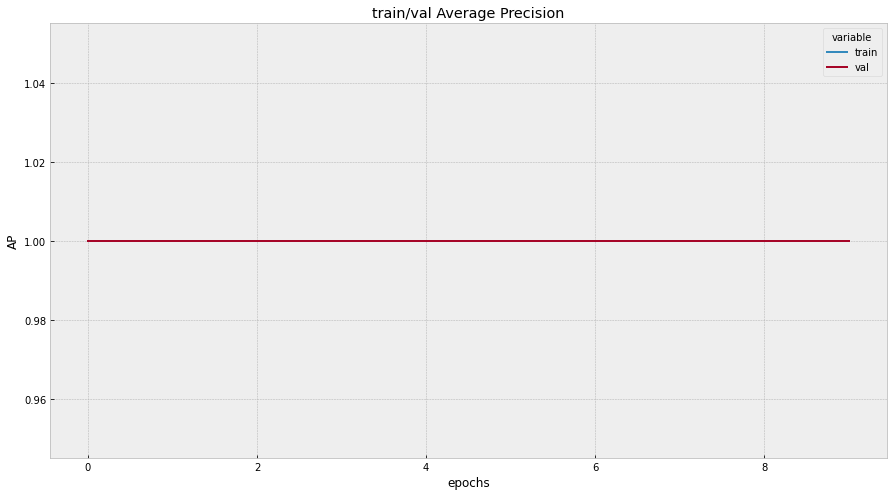

In [ ]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"});
plt.figure(figsize=(15,8));
g = sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable");
g.set_title("train/val Average Precision");
g.set_ylabel("AP");


Somehow it's also overfitted on validation set, let's check on test set

In [ ]:
y_pred = net(torch.tensor(X_test_pr).float())

In [ ]:
print("AP on test set: ",average_precision_score(y_test_pr,y_pred.detach().numpy(),average="micro"))

AP on test set:  0.9920586265880607


Results are still very good. They are slighly (0.005) worse than TF results, but this can be due to stochastic nature of the process



---



# 2. CV-part

## Tensorflow/Keras

In [ ]:
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from  tensorflow.keras.utils import image_dataset_from_directory
import pathlib

In [ ]:
batch_size = 32
img_height = 192
img_width = 192

IMG_SIZE = (img_height,img_width)

In [ ]:
train_path = "/content/drive/MyDrive/hotdog__not_hotdog/train/"
train_df = image_dataset_from_directory(train_path, labels='inferred',
                                        validation_split=0.2,
                                        subset="training",
                                        seed=123,
                                        image_size = (img_height, img_width), batch_size = batch_size)

val_df = image_dataset_from_directory(train_path, labels='inferred',
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=123,
                                        image_size = (img_height, img_width), batch_size = batch_size)

test_path = "/content/drive/MyDrive/hotdog__not_hotdog/test/"
test_df = image_dataset_from_directory(test_path, labels='inferred', image_size = IMG_SIZE, batch_size = batch_size)

Found 498 files belonging to 2 classes.
Using 399 files for training.
Found 498 files belonging to 2 classes.
Using 99 files for validation.
Found 500 files belonging to 2 classes.


In [ ]:
for image_batch, labels_batch in train_df:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 192, 192, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def plot_learn_curve():
 
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(epochs)

  plt.figure(figsize=(20, 6));
  plt.subplot(1, 2, 1);
  plt.plot(epochs_range, acc, label='Training Accuracy');
  plt.plot(epochs_range, val_acc, label='Validation Accuracy');
  plt.legend();
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2);
  plt.plot(epochs_range, loss, label='Training Loss');
  plt.plot(epochs_range, val_loss, label='Validation Loss');
  plt.legend();
  plt.title('Training and Validation Loss');
  plt.show();

### 2.1 Baseline model

In [ ]:

model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',
optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
metrics='accuracy')

In [ ]:
epochs=25
history = model.fit(
  train_df,
  validation_data=val_df,
  epochs=epochs
)

Epoch 1/25
13/13 [==============================] - 9s 112ms/step - loss: 2.3167 - accuracy: 0.5414 - val_loss: 0.6840 - val_accuracy: 0.5253
Epoch 2/25
13/13 [==============================] - 1s 75ms/step - loss: 0.6856 - accuracy: 0.5639 - val_loss: 0.6667 - val_accuracy: 0.6061
Epoch 3/25
13/13 [==============================] - 1s 74ms/step - loss: 0.7285 - accuracy: 0.6115 - val_loss: 0.6735 - val_accuracy: 0.5657
Epoch 4/25
13/13 [==============================] - 1s 72ms/step - loss: 0.6565 - accuracy: 0.6416 - val_loss: 0.6527 - val_accuracy: 0.6061
Epoch 5/25
13/13 [==============================] - 1s 72ms/step - loss: 0.6338 - accuracy: 0.6667 - val_loss: 0.6408 - val_accuracy: 0.6566
Epoch 6/25
13/13 [==============================] - 1s 72ms/step - loss: 0.5129 - accuracy: 0.7519 - val_loss: 1.2420 - val_accuracy: 0.4747
Epoch 7/25
13/13 [==============================] - 1s 72ms/step - loss: 0.5201 - accuracy: 0.7569 - val_loss: 2.1355 - val_accuracy: 0.4747
Epoch 8/25
1

#### Learning curve

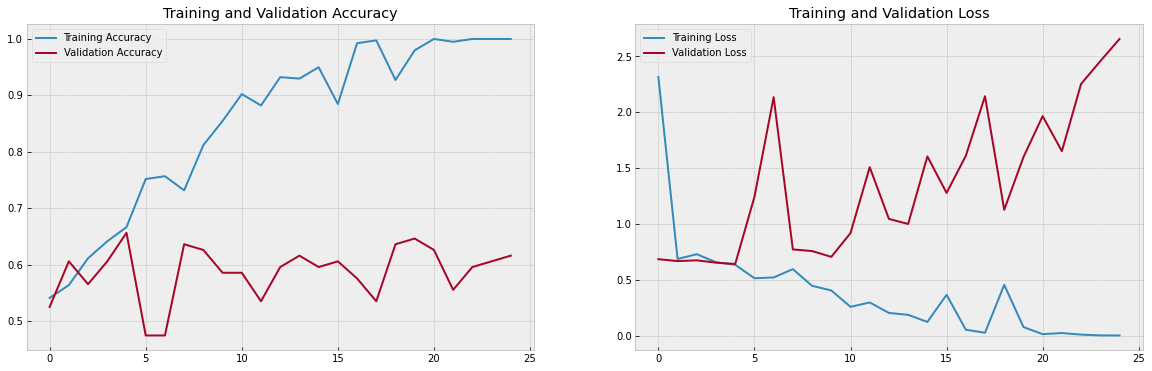

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 6));
plt.subplot(1, 2, 1);
plt.plot(epochs_range, acc, label='Training Accuracy');
plt.plot(epochs_range, val_acc, label='Validation Accuracy');
plt.legend();
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2);
plt.plot(epochs_range, loss, label='Training Loss');
plt.plot(epochs_range, val_loss, label='Validation Loss');
plt.legend();
plt.title('Training and Validation Loss');
plt.show();

Model tends to overfit a lot and shows only 60% accuracy on validation set, but we will use it as a baseline to tune.

### 2.2 Augmentation 

Augmentation using Flip, Rotation and Zoom 

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's add augmentation and Dropout layers

In [ ]:
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',
optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
metrics='accuracy')

In [ ]:
epochs=20
history = model.fit(
  train_df,
  validation_data=val_df,
  epochs=epochs
)

Epoch 1/20
13/13 [==============================] - 3s 102ms/step - loss: 1.1992 - accuracy: 0.5013 - val_loss: 0.6847 - val_accuracy: 0.5455
Epoch 2/20
13/13 [==============================] - 1s 83ms/step - loss: 0.6867 - accuracy: 0.5288 - val_loss: 0.6742 - val_accuracy: 0.6162
Epoch 3/20
13/13 [==============================] - 1s 81ms/step - loss: 0.6953 - accuracy: 0.5664 - val_loss: 0.6718 - val_accuracy: 0.6465
Epoch 4/20
13/13 [==============================] - 1s 83ms/step - loss: 0.6886 - accuracy: 0.5614 - val_loss: 0.6770 - val_accuracy: 0.6465
Epoch 5/20
13/13 [==============================] - 1s 82ms/step - loss: 0.6816 - accuracy: 0.5990 - val_loss: 0.6649 - val_accuracy: 0.6566
Epoch 6/20
13/13 [==============================] - 1s 79ms/step - loss: 0.6847 - accuracy: 0.5288 - val_loss: 0.6658 - val_accuracy: 0.5960
Epoch 7/20
13/13 [==============================] - 1s 81ms/step - loss: 0.6801 - accuracy: 0.5915 - val_loss: 0.6735 - val_accuracy: 0.6162
Epoch 8/20
1

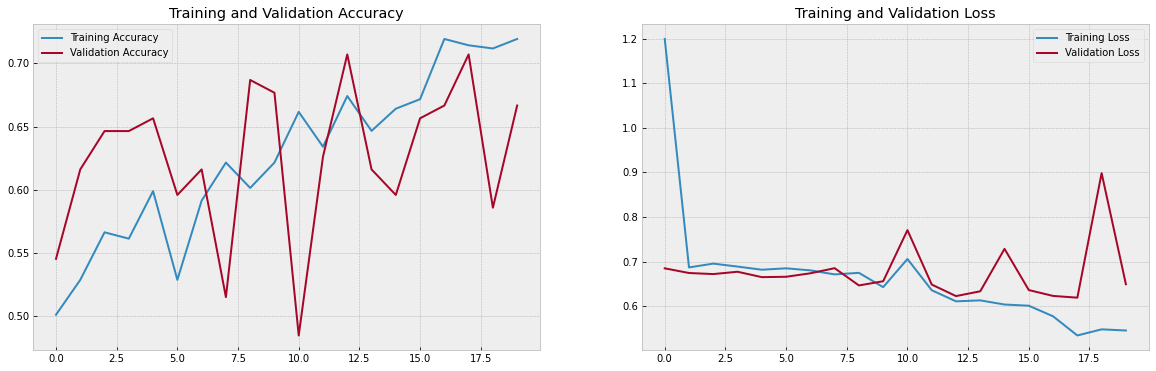

In [ ]:
plot_learn_curve()

In [ ]:
loss, accuracy = model.evaluate(test_df)
print('Test accuracy :', accuracy)

16/16 [==============================] - 0s 16ms/step - loss: 0.7266 - accuracy: 0.6100
Test accuracy : 0.6100000143051147


Now there is no overfitting but accuracy is only 61% on test set.

To achieve better results let's use *pre-trained models*

### 2.3 Pre-trained model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights = 'imagenet', 
                                                                         include_top = False, 
                                                                         input_shape = IMG_SHAPE)

#freeze the model
base_model.trainable = False

In [ ]:
base_model.summary()

Let's follow how the batch is transformed

In [ ]:
image_batch, label_batch = next(iter(train_df))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 1536)


So we need layers to convert from ( 6, 6, 1536)  to 1.

Let's do this with GlobalPooling to make 1536 values, and than add Dense(1)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#come from 6x6x1536 to 1-D 1536 array
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now let's compile these tranfromation to a model

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)

#since InceptionResNetV2 use [-1,1] scale instead of [0,1]
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)(x)

x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 192, 192, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 192, 192, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 1537

54 **million** parameters are frozen and *1500* is trained :) 

In [ ]:
epochs = 20

In [ ]:
history = model.fit(train_df,
                    epochs=epochs,
                    validation_data=val_df)

Epoch 1/20
13/13 [==============================] - 29s 959ms/step - loss: 1.6321 - accuracy: 0.4987 - val_loss: 0.6965 - val_accuracy: 0.4747
Epoch 2/20
13/13 [==============================] - 7s 552ms/step - loss: 0.7977 - accuracy: 0.5238 - val_loss: 0.6966 - val_accuracy: 0.5253
Epoch 3/20
13/13 [==============================] - 7s 540ms/step - loss: 0.7052 - accuracy: 0.4536 - val_loss: 0.6958 - val_accuracy: 0.4747
Epoch 4/20
13/13 [==============================] - 7s 538ms/step - loss: 0.6943 - accuracy: 0.5063 - val_loss: 0.6913 - val_accuracy: 0.4747
Epoch 5/20
13/13 [==============================] - 7s 537ms/step - loss: 0.6958 - accuracy: 0.5138 - val_loss: 0.6732 - val_accuracy: 0.4747
Epoch 6/20
13/13 [==============================] - 7s 539ms/step - loss: 0.6828 - accuracy: 0.5163 - val_loss: 0.6404 - val_accuracy: 0.4747
Epoch 7/20
13/13 [==============================] - 7s 540ms/step - loss: 0.7285 - accuracy: 0.5263 - val_loss: 0.6472 - val_accuracy: 0.6364
Epoch

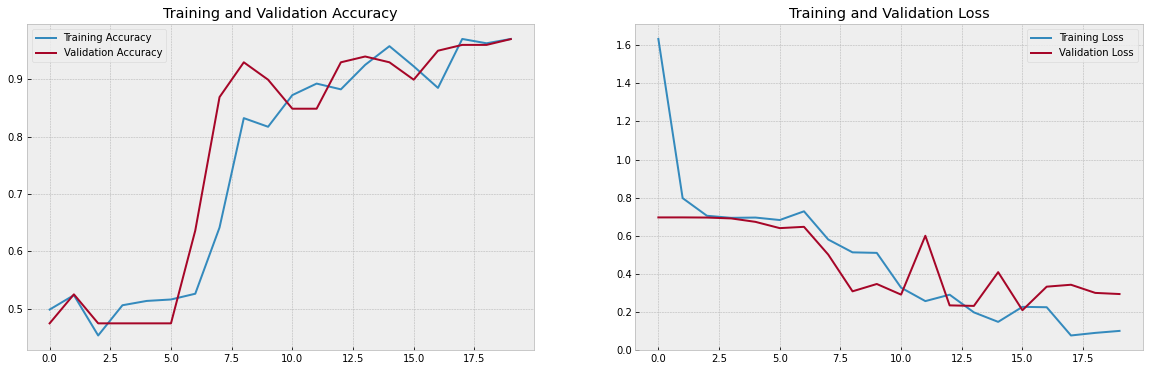

In [ ]:
#save to use later with fine-tuning
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss_func = history.history['loss']
val_loss = history.history['val_loss']


plot_learn_curve()

Accuracy increased up to 90%

Validation accuracy is higher probably because of lack of the data (validation size is only 99 examples)
Let's check on test dataset

In [ ]:
loss, accuracy = model.evaluate(test_df)
print('Test accuracy :', accuracy)

16/16 [==============================] - 5s 306ms/step - loss: 0.2088 - accuracy: 0.9180
Test accuracy : 0.9179999828338623


Test accuracy is 0.91% which is very good!!!

### 2.4 Unfreeze pre-trained layer

In [ ]:
#unfreezing
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  780


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = int(len(base_model.layers)*0.75) #tune 25% of layers

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.00001),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

#continue learning with unfreezed layers

history_fine = model.fit(train_df,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_df)

Epoch 20/30
13/13 [==============================] - 32s 895ms/step - loss: 0.0988 - accuracy: 0.9599 - val_loss: 0.2706 - val_accuracy: 0.9495
Epoch 21/30
13/13 [==============================] - 7s 557ms/step - loss: 0.0982 - accuracy: 0.9574 - val_loss: 0.2661 - val_accuracy: 0.9495
Epoch 22/30
13/13 [==============================] - 7s 561ms/step - loss: 0.0539 - accuracy: 0.9749 - val_loss: 0.2690 - val_accuracy: 0.9495
Epoch 23/30
13/13 [==============================] - 7s 558ms/step - loss: 0.0818 - accuracy: 0.9699 - val_loss: 0.2620 - val_accuracy: 0.9495
Epoch 24/30
13/13 [==============================] - 7s 557ms/step - loss: 0.0604 - accuracy: 0.9774 - val_loss: 0.2658 - val_accuracy: 0.9495
Epoch 25/30
13/13 [==============================] - 7s 560ms/step - loss: 0.0660 - accuracy: 0.9699 - val_loss: 0.2657 - val_accuracy: 0.9495
Epoch 26/30
13/13 [==============================] - 7s 559ms/step - loss: 0.0773 - accuracy: 0.9674 - val_loss: 0.2735 - val_accuracy: 0.959

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss_func += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

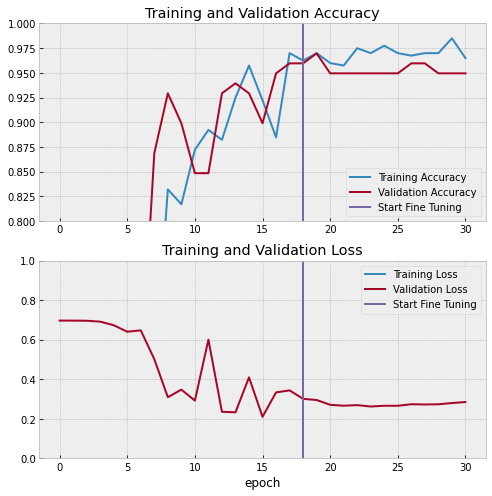

In [ ]:
#not using func since adding some lines

plt.figure(figsize=(8, 8));
plt.subplot(2, 1, 1);
plt.plot(acc, label='Training Accuracy');
plt.plot(val_acc, label='Validation Accuracy');
plt.ylim([0.8, 1]);
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
          plt.ylim(), label='Start Fine Tuning');
plt.legend(loc='lower right');
plt.title('Training and Validation Accuracy');

plt.subplot(2, 1, 2);
plt.plot(loss, label='Training Loss');
plt.plot(val_loss, label='Validation Loss');
plt.ylim([0, 1.0]);
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
         plt.ylim(), label='Start Fine Tuning');
plt.legend(loc='upper right');
plt.title('Training and Validation Loss');
plt.xlabel('epoch');
plt.show();

In [ ]:
loss, accuracy = model.evaluate(test_df)
print('Test accuracy :', accuracy)

16/16 [==============================] - 5s 306ms/step - loss: 0.4264 - accuracy: 0.9120
Test accuracy : 0.9120000004768372


Model somehow performed even worse after restarning, probably take too much layers? Good point to investigate later

### 2.5 Compare of different basemodels

Let's optimize some code -- we will use same structure with only changing base_model

In [ ]:
def build_compile_pretrained_model(base_model):
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  x = data_augmentation(inputs)
  
  x = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.001
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [ ]:
def fit_evaluate(model):
  model.fit(train_df,
         epochs=epochs,
         validation_data=val_df)
  loss, accuracy = model.evaluate(test_df)
  return accuracy

###### InceptionResNetV2

In [ ]:
InceptionResNetV2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights = 'imagenet', 
                                                                         include_top = False, 
                                                                         input_shape = IMG_SHAPE)
#freeze the model
InceptionResNetV2.trainable = False
model = build_compile_pretrained_model(InceptionResNetV2)

In [ ]:
#commented to avoid calculating again

resnet_v2_acc = fit_evaluate(model)
resnet_v2_acc

Epoch 1/20
13/13 [==============================] - 23s 744ms/step - loss: 0.5435 - accuracy: 0.7494 - val_loss: 0.3210 - val_accuracy: 0.8485
Epoch 2/20
13/13 [==============================] - 5s 414ms/step - loss: 0.3568 - accuracy: 0.8446 - val_loss: 0.2205 - val_accuracy: 0.9091
Epoch 3/20
13/13 [==============================] - 5s 416ms/step - loss: 0.3804 - accuracy: 0.8296 - val_loss: 0.2148 - val_accuracy: 0.8990
Epoch 4/20
13/13 [==============================] - 5s 418ms/step - loss: 0.2861 - accuracy: 0.8722 - val_loss: 0.1826 - val_accuracy: 0.9192
Epoch 5/20
13/13 [==============================] - 5s 417ms/step - loss: 0.3183 - accuracy: 0.8622 - val_loss: 0.1936 - val_accuracy: 0.9192
Epoch 6/20
13/13 [==============================] - 5s 417ms/step - loss: 0.2595 - accuracy: 0.8847 - val_loss: 0.1726 - val_accuracy: 0.9293
Epoch 7/20
13/13 [==============================] - 5s 417ms/step - loss: 0.2656 - accuracy: 0.8797 - val_loss: 0.1879 - val_accuracy: 0.9192
Epoch

0.9120000004768372

###### MobileNetV2

In [ ]:
MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
MobileNetV2.trainable = False

In [ ]:
MobNet = build_compile_pretrained_model(MobileNetV2)

In [ ]:
MobNetAcc = fit_evaluate(MobNet)
MobNetAcc

Epoch 1/20
13/13 [==============================] - 8s 244ms/step - loss: 0.6833 - accuracy: 0.6165 - val_loss: 0.4797 - val_accuracy: 0.7475
Epoch 2/20
13/13 [==============================] - 1s 110ms/step - loss: 0.4940 - accuracy: 0.7669 - val_loss: 0.3788 - val_accuracy: 0.8283
Epoch 3/20
13/13 [==============================] - 1s 110ms/step - loss: 0.3948 - accuracy: 0.8321 - val_loss: 0.3253 - val_accuracy: 0.8485
Epoch 4/20
13/13 [==============================] - 1s 111ms/step - loss: 0.3509 - accuracy: 0.8722 - val_loss: 0.2948 - val_accuracy: 0.8586
Epoch 5/20
13/13 [==============================] - 1s 110ms/step - loss: 0.3024 - accuracy: 0.8722 - val_loss: 0.2773 - val_accuracy: 0.8586
Epoch 6/20
13/13 [==============================] - 1s 109ms/step - loss: 0.3207 - accuracy: 0.8772 - val_loss: 0.2585 - val_accuracy: 0.8687
Epoch 7/20
13/13 [==============================] - 1s 111ms/step - loss: 0.2665 - accuracy: 0.8822 - val_loss: 0.2496 - val_accuracy: 0.8889
Epoch 

0.8920000195503235

###### VGG19

In [ ]:
base_model_vgg19 = tf.keras.applications.vgg19.VGG19(weights = 'imagenet', include_top = False, input_shape = IMG_SHAPE)
base_model_vgg19.trainable = False

vgg19 = build_compile_pretrained_model(base_model_vgg19)

In [ ]:
vgg19_acc = fit_evaluate(vgg19)
vgg19_acc

Epoch 1/20
13/13 [==============================] - 19s 775ms/step - loss: 0.7257 - accuracy: 0.4662 - val_loss: 0.6991 - val_accuracy: 0.5354
Epoch 2/20
13/13 [==============================] - 4s 304ms/step - loss: 0.7019 - accuracy: 0.4837 - val_loss: 0.6888 - val_accuracy: 0.5253
Epoch 3/20
13/13 [==============================] - 4s 307ms/step - loss: 0.7013 - accuracy: 0.5088 - val_loss: 0.6770 - val_accuracy: 0.5758
Epoch 4/20
13/13 [==============================] - 4s 301ms/step - loss: 0.6857 - accuracy: 0.5489 - val_loss: 0.6599 - val_accuracy: 0.6263
Epoch 5/20
13/13 [==============================] - 4s 301ms/step - loss: 0.6783 - accuracy: 0.6065 - val_loss: 0.6510 - val_accuracy: 0.6667
Epoch 6/20
13/13 [==============================] - 4s 302ms/step - loss: 0.6747 - accuracy: 0.5514 - val_loss: 0.6468 - val_accuracy: 0.6263
Epoch 7/20
13/13 [==============================] - 4s 301ms/step - loss: 0.6759 - accuracy: 0.5664 - val_loss: 0.6344 - val_accuracy: 0.6566
Epoch

0.7919999957084656

###### Xception

In [ ]:
base_model_Xception = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = IMG_SHAPE)
base_model_Xception.trainable = False

Xception = build_compile_pretrained_model(base_model_Xception)

In [ ]:
Xception_acc = fit_evaluate(Xception)
Xception_acc

Epoch 1/20
13/13 [==============================] - 12s 508ms/step - loss: 0.6612 - accuracy: 0.5915 - val_loss: 0.4329 - val_accuracy: 0.8283
Epoch 2/20
13/13 [==============================] - 4s 303ms/step - loss: 0.4229 - accuracy: 0.8396 - val_loss: 0.3046 - val_accuracy: 0.9091
Epoch 3/20
13/13 [==============================] - 4s 302ms/step - loss: 0.3462 - accuracy: 0.8446 - val_loss: 0.2731 - val_accuracy: 0.9192
Epoch 4/20
13/13 [==============================] - 4s 306ms/step - loss: 0.3206 - accuracy: 0.8647 - val_loss: 0.2426 - val_accuracy: 0.9394
Epoch 5/20
13/13 [==============================] - 4s 302ms/step - loss: 0.3024 - accuracy: 0.8772 - val_loss: 0.2355 - val_accuracy: 0.9394
Epoch 6/20
13/13 [==============================] - 4s 306ms/step - loss: 0.2758 - accuracy: 0.8747 - val_loss: 0.2212 - val_accuracy: 0.9394
Epoch 7/20
13/13 [==============================] - 4s 305ms/step - loss: 0.2511 - accuracy: 0.9123 - val_loss: 0.2100 - val_accuracy: 0.9495
Epoch

0.9020000100135803

###### **Summary**

In [ ]:
print("Accuracy of resnet_v2: ", resnet_v2_acc);
print("Accuracy of MobileNetV2: ", MobNetAcc);
print("Accuracy of VGG19: ",vgg19_acc);
print("Accuracy of Xception: ",Xception_acc);

Accuracy of resnet_v2:  0.9120000004768372
Accuracy of MobileNetV2:  0.8920000195503235
Accuracy of VGG19:  0.7919999957084656
Accuracy of Xception:  0.9020000100135803


According to these results resnet perfomed better in terms of accuracy, but there is important notes:

1) Speed

ResNet was also the slowest one

2) Parameters

Some models work better with specific IMG size and other parameters, also, same network structure was used, which could not be oprimal.

3) Epochs

We used same 20 epochs (which was enough to original resnet to fit). This can be not oprimal parameters for such models as VGG19, it is possible that VGG19 was underfitted

### 2.6 Optimal Learning rate

In [ ]:
from tensorflow.keras.callbacks import Callback

Let's used created LRFinder (https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py)

In [ ]:
class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [ ]:
lr_finder = LRFinder()

In [ ]:
e#let's use pre-trained model

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)

#since InceptionResNetV2 use [-1,1] scale instead of [0,1]
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)(x)

x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

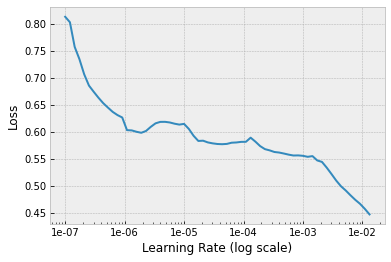

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
_ = model.fit(train_df, epochs=5, callbacks=[lr_finder], verbose=False)

lr_finder.plot()

So, according to this results optimal learning rate is between [0.01 and 0.1]

Need to mention that learning rate is that big since it is used on pretrained model only for last, prediction layer. That's why it could be really big